In [1]:
import sys
sys.path.append('../src')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import tensorflow as tf
from gait.utils import get_overlap_data_all_sessions,  split_test_train_by_subjects, get_overlap_data_all_sessions
from gait.training import train_cnn_model_simple
from gait.evalution import save_history, save_test_history, save_accuracy_loss_figure, save_confusion_matrix_figure, compute_validations_predictions

In [2]:
def predict_tflite_from_saved_model(tflite_path, x_test):
    # Prepare the test data
    x_test_ = x_test.copy()
    n, win_len, channel, _ = x_test.shape
    # x_test_ = x_test_.reshape((x_test.size, 1))
    x_test_ = x_test_.astype(np.float32)

    # Initialize the TFLite interpreter
    interpreter = tf.lite.Interpreter(model_path=str(tflite_path))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    print('input details index', input_details)

    # If required, quantize the input layer (from float to integer)
    input_scale, input_zero_point = input_details["quantization"]
    if (input_scale, input_zero_point) != (0.0, 0):
        x_test_ = x_test_ / input_scale + input_zero_point
        x_test_ = x_test_.astype(input_details["dtype"])

    # Invoke the interpreter
    y_pred = np.empty((n, 5), dtype=output_details["dtype"])
    for i in range(len(x_test_)):
        interpreter.set_tensor(input_details["index"], [x_test_[i]])
        interpreter.invoke()
        # print(interpreter.get_tensor(output_details["index"])[0])
        y_pred[i] = interpreter.get_tensor(output_details["index"])[0]

    # If required, dequantized the output layer (from integer to float)
    output_scale, output_zero_point = output_details["quantization"]
    if (output_scale, output_zero_point) != (0.0, 0):
        y_pred = y_pred.astype(np.float32)
        y_pred = (y_pred - output_zero_point) * output_scale

    return y_pred

In [3]:
OVERLAP_PERCENT = 90
exclude_subjects = ['ddAeJA42PXvwthbW', 'nan',
                    'MMuX9YIh4NTbLZLM',
                    'NKdnm6cN3KKAx7R4',
                    'PE8D53oX060qLbdX',
                    'xYdtS1F8tDyjEIgN',
                    'EUbKPOSQgjccjtvi',
                    'LLZjAPTyj7muHsEf',
                    'cbOZWnI7s1y8oLD4',
                    '1ZstYhEKzKKfGnMW',
                    'bQsRwKxgJiXTzo6P',
                    'sUZBISq61Y7I5tqQ',
                    '19AoxD1bgrDckd2p',
                    'wtyNo4LYaWXrkzA7',
                    ]

In [5]:
OVERLAP_PERCENT=80
X, y, subjects = get_overlap_data_all_sessions(OVERLAP_PERCENT)
# REMOVE UNWANTED SUBJECTS
indexes = np.where(subjects == exclude_subjects)
X = np.delete(X, indexes[0], axis=0)
y = np.delete(y, indexes[0], axis=0)
subjects = np.delete(subjects, indexes[0], axis=0)
# END REMOVE UNWANTED SUBJECTS

X_train, X_test, y_train, y_test, y_train_non_encoded, y_test_non_encoded = split_test_train_by_subjects(
    X, y, subjects, train_percent=0.8)

In [6]:
keras_model_path = './best_model.91-0.52-0.82.hdf5';
tf_lite_model_path ='./final-cnn.tflite'
float_quantized_model_path = './float-quantized-model.tflite'
int_quantized_model_path = './int-quantized-model.tflite'

In [7]:
keras_model = tf.keras.models.load_model(keras_model_path)


In [9]:
X_t = X_test.reshape(-1, X_test.shape[1], X_test.shape[2], 1).astype(np.uint8)


In [10]:
y_test_pred_tflite = predict_tflite_from_saved_model(tf_lite_model_path, X_t)
y_test_pred_float_tflite = predict_tflite_from_saved_model(float_quantized_model_path, X_t)
y_test_pred_int_tflite = predict_tflite_from_saved_model(int_quantized_model_path, X_t)

input details index {'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 128,   9,   1], dtype=int32), 'shape_signature': array([ -1, 128,   9,   1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
input details index {'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 128,   9,   1], dtype=int32), 'shape_signature': array([ -1, 128,   9,   1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
input details index {'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 128,   9,   1], dtype=int32), 'shape_signature': array([ -1, 128,   9,   1], dtype=int32), 'dtype': <class 'num

In [11]:
max_y_pred_tflite = np.argmax(y_test_pred_tflite, axis=1)
max_y_pred_float_tflite = np.argmax(y_test_pred_float_tflite, axis=1)
max_y_pred_int_tflite = np.argmax(y_test_pred_int_tflite, axis=1)
max_y_test = np.argmax(y_test, axis=1)

In [12]:
from sklearn import metrics

In [15]:
def plot_confusion_mat(validations, predictions, title):
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='magma_r',
                linecolor='white',
                linewidths=1,
                annot=True,
                fmt='d')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

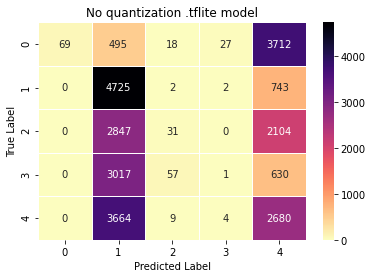

In [18]:
plot_confusion_mat(max_y_test, max_y_pred_tflite, 'Inference of test data from a in .tflite extension model')

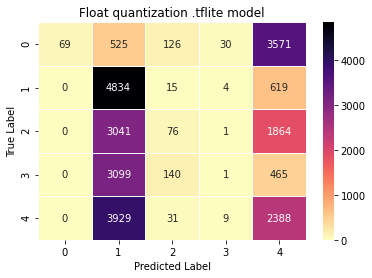

In [19]:
plot_confusion_mat(max_y_test, max_y_pred_float_tflite, 'Inference of test data from a float quantized model')

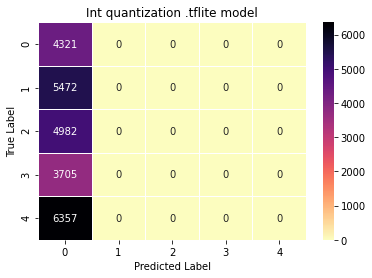

In [20]:
plot_confusion_mat(max_y_test, max_y_pred_int_tflite, 'Inference of test data from a in quantized model')